# Exploratory Data Analysis (EDA)

# Importing Libraries

In [ ]:
# Data handling and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine learning: splitting, scaling, balancing, metrics, utils
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import class_weight
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    confusion_matrix, roc_curve, auc
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Imbalanced learning
from imblearn.over_sampling import SMOTE

# Deep learning: TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, BatchNormalization, Dropout, Concatenate,
    Add, Multiply, LeakyReLU
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.metrics import AUC

# Model persistence
import joblib

# Utilities
import time
import warnings
from math import ceil

# Ignore warnings for clean output
warnings.filterwarnings('ignore')

Loading Datasets

In [47]:
# Clinical Datasets
African = pd.read_csv("/Users/mohammedbasem/Desktop/T2D-Prediction-System--Data-Fusion-for-Enhanced-Decision-Making/processed_datasets/clinical/African_pro.csv")
Bangladesh = pd.read_csv("/Users/mohammedbasem/Desktop/T2D-Prediction-System--Data-Fusion-for-Enhanced-Decision-Making/processed_datasets/clinical/Bangladesh_pro.csv")
Iraq = pd.read_csv("/Users/mohammedbasem/Desktop/T2D-Prediction-System--Data-Fusion-for-Enhanced-Decision-Making/processed_datasets/clinical/Iraq_pro.csv")

# Genetic Datasets
inter_genetic = pd.read_csv("/Users/mohammedbasem/Desktop/T2D-Prediction-System--Data-Fusion-for-Enhanced-Decision-Making/processed_datasets/genetic/inter_genetic_dataset.csv")
normal_genetic = pd.read_csv("/Users/mohammedbasem/Desktop/T2D-Prediction-System--Data-Fusion-for-Enhanced-Decision-Making/processed_datasets/genetic/normal_genetic_dataset.csv")

Checking Target Columns

In [48]:
print(African.columns, "\n")
print(Bangladesh.columns, "\n")
print(Iraq.columns, "\n")
print(inter_genetic.columns, "\n")
print(normal_genetic.columns)

Index(['Cholesterol', 'Glucose', 'HDL Chol', 'Chol/HDL ratio', 'Age', 'Gender',
       'Height', 'Weight', 'BMI', 'Systolic BP', 'Diastolic BP', 'waist',
       'hip', 'Waist/hip ratio', 'Diabetes'],
      dtype='object') 

Index(['age', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'glucose', 'height',
       'weight', 'bmi', 'family_diabetes', 'hypertensive',
       'family_hypertension', 'cardiovascular_disease', 'stroke',
       'gender_Encoded', 'diabetic_Encoded'],
      dtype='object') 

Index(['Age', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI',
       'Gender_Encoded', 'Class_Encoded'],
      dtype='object') 

Index(['STUDY', 'DISEASE_DESCRIPTION', 'REGION', 'CHR_ID', 'CHR_POS',
       'MAPPED_GENE', 'UPSTREAM_GENE_ID', 'DOWNSTREAM_GENE_ID',
       'UPSTREAM_GENE_DISTANCE', 'DOWNSTREAM_GENE_DISTANCE', 'SNPS', 'MERGED',
       'GENOMIC_CONTEXT', 'INTERGENIC', 'RISK_ALLELE_FREQUENCY', 'PVALUE',
       'PVALUE_MLOG', 'EFFECT_SIZE', 'CASE_PERCENTAGE', 'CI_LOWER_

Checking Data Types 

In [49]:
print(African.dtypes, '\n')
print(Bangladesh.dtypes, '\n')
print(Iraq.dtypes, '\n')
print(inter_genetic.dtypes, '\n')
print(normal_genetic.dtypes, '\n')

Cholesterol          int64
Glucose              int64
HDL Chol             int64
Chol/HDL ratio     float64
Age                  int64
Gender               int64
Height               int64
Weight               int64
BMI                float64
Systolic BP          int64
Diastolic BP         int64
waist                int64
hip                  int64
Waist/hip ratio    float64
Diabetes             int64
dtype: object 

age                         int64
pulse_rate                  int64
systolic_bp                 int64
diastolic_bp                int64
glucose                   float64
height                    float64
weight                    float64
bmi                       float64
family_diabetes             int64
hypertensive                int64
family_hypertension         int64
cardiovascular_disease      int64
stroke                      int64
gender_Encoded              int64
diabetic_Encoded            int64
dtype: object 

Age                 int64
Urea              float64
C

Checking number of columns and rows

In [50]:
print(African.shape, '\n')
print(Bangladesh.shape, '\n')
print(Iraq.shape, '\n')
print(inter_genetic.shape, '\n')
print(normal_genetic.shape, '\n')

(390, 15) 

(5437, 15) 

(786, 12) 

(1110, 28) 

(2141, 25) 



Target columns renaming

In [52]:
# Rename clinical targets to 'T2D'
African.rename(columns={'Diabetes':'T2D'},      inplace=True)
Bangladesh.rename(columns={'diabetic_Encoded':'T2D'}, inplace=True)
Iraq.rename(columns={'Class_Encoded':'T2D'},    inplace=True)

# Ensure genetic sets have a 'T2D' column (all positives)
for df in (inter_genetic, normal_genetic):
    if 'T2D' not in df.columns:
        df['T2D'] = 1

# Data Preprocessing

Splitting Clinical Datasets


In [53]:
# Setting split sizes and random state
test_size_clin = 0.20
val_size_clin  = 0.15
rs             = 42

# Defining function to split clinical dataset into train, validation, and test sets
def split_clinical(df):
    # Splitting into train+val and test sets
    X_tr_val, X_test, y_tr_val, y_test = train_test_split(
        df.drop(columns='T2D'), df['T2D'],
        test_size=test_size_clin, stratify=df['T2D'], random_state=rs
    )
    # Splitting train+val into separate train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_tr_val, y_tr_val,
        test_size=val_size_clin, stratify=y_tr_val, random_state=rs
    )
    return X_train, y_train, X_val, y_val, X_test, y_test

# Splitting datasets
X_train_african, y_train_african, X_val_african, y_val_african, X_test_african, y_test_african = split_clinical(African)
X_train_bangladesh, y_train_bangladesh, X_val_bangladesh, y_val_bangladesh, X_test_bangladesh, y_test_bangladesh = split_clinical(Bangladesh)
X_train_iraq, y_train_iraq, X_val_iraq, y_val_iraq, X_test_iraq, y_test_iraq = split_clinical(Iraq)

Scaling and Imputing Clinical Datasets


In [54]:
# Creating an imputer for missing values using the mean strategy
imputer = SimpleImputer(strategy='mean')

# Preprocessing function: scaling and imputing clinical features
def preprocess_clinical(X_train, X_val, X_test):
    # Selecting numerical columns
    num_cols = X_train.select_dtypes(include=[np.number]).columns
    # Fitting a standard scaler on training data
    scaler = StandardScaler().fit(X_train[num_cols])
    # Transforming train, validation, and test sets
    X_tr_sc   = scaler.transform(X_train[num_cols])
    X_val_sc  = scaler.transform(X_val[num_cols])
    X_test_sc = scaler.transform(X_test[num_cols])
    # Imputing missing values
    return (
        imputer.fit_transform(X_tr_sc),
        imputer.transform(X_val_sc),
        imputer.transform(X_test_sc)
    )

# Preprocessing datasets

X_train_african_sc, X_val_african_sc, X_test_african_sc = preprocess_clinical(
    X_train_african, X_val_african, X_test_african
)
X_train_bangladesh_sc, X_val_bangladesh_sc, X_test_bangladesh_sc = preprocess_clinical(
    X_train_bangladesh, X_val_bangladesh, X_test_bangladesh
)
X_train_iraq_sc, X_val_iraq_sc, X_test_iraq_sc = preprocess_clinical(
    X_train_iraq, X_val_iraq, X_test_iraq
)

Building GAN models and generating synthetic negative samples

In [55]:
# Building the generator model for GAN
def build_generator(input_dim, output_dim):
    return Sequential([
        Dense(128, input_dim=input_dim), LeakyReLU(0.2), BatchNormalization(),
        Dense(256),                      LeakyReLU(0.2), BatchNormalization(),
        Dense(output_dim, activation='tanh')
    ])

# Building and compiling the discriminator model for GAN
def build_discriminator(input_dim):
    disc = Sequential([
        Dense(256, input_dim=input_dim), LeakyReLU(0.2),
        Dense(128),                      LeakyReLU(0.2),
        Dense(1, activation='sigmoid')
    ])
    disc.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return disc

# Generating synthetic negative samples using the trained generator
def generate_synthetic_negatives(real_df, generator, scaler, num_cols, label_col='T2D'):
    n = len(real_df)
    # Generating random noise for the generator input
    z = np.random.normal(0, 1, (n, generator.input_shape[1])).astype(np.float32)
    # Predicting synthetic features using the generator
    fake = generator.predict(z, verbose=0)
    # Inversely scaling numeric features to original scale
    synth_num = scaler.inverse_transform(fake)
    synth_df = pd.DataFrame(synth_num, columns=num_cols)
    synth_df[label_col] = 0  # Assigning label 0 for synthetic negatives
    # Selecting real positive samples (numeric only)
    pos_df = real_df[num_cols + [label_col]].copy()
    # Combining synthetic negatives and real positives
    balanced = pd.concat([pos_df, synth_df], ignore_index=True)
    X = balanced[num_cols]
    y = balanced[label_col]
    return X, y

Processing genetic datasets with GAN-based data balancing

In [56]:
def process_genetic(
    df,
    test_size,
    val_size,
    rs,
    noise_dim=100,
    epochs=500,    
    batch_size=64
):
    # Splitting positives into train+val vs test sets
    X_all = df.drop(columns='T2D')
    y_all = df['T2D']
    X_tr_val, X_test, y_tr_val, y_test = train_test_split(
        X_all, y_all, test_size=test_size, stratify=y_all, random_state=rs
    )
    # Splitting train+val into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_tr_val, y_tr_val, test_size=val_size, stratify=y_tr_val, random_state=rs
    )
    # Selecting numeric feature columns only
    num_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
    # Scaling training positives using MinMaxScaler
    scaler = MinMaxScaler().fit(X_train[num_cols])
    train_scaled = scaler.transform(X_train[num_cols]).astype(np.float32)
    # Building and compiling GAN components (generator and discriminator)
    generator     = build_generator(noise_dim, train_scaled.shape[1])
    discriminator = build_discriminator(train_scaled.shape[1])
    discriminator.trainable = False
    gan = Sequential([generator, discriminator])
    gan.compile(loss='binary_crossentropy', optimizer=Adam())
    # Training GAN for given number of epochs
    for ep in range(epochs):
        idx   = np.random.randint(0, len(train_scaled), batch_size)
        real  = train_scaled[idx]
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        fake  = generator.predict(noise, verbose=0)
        discriminator.trainable = True
        discriminator.train_on_batch(real, np.ones((batch_size, 1)))
        discriminator.train_on_batch(fake, np.zeros((batch_size, 1)))
        discriminator.trainable = False
        gan.train_on_batch(
            np.random.normal(0, 1, (batch_size, noise_dim)),
            np.ones((batch_size, 1))
        )
        if ep % 50 == 0:
            print(f"[GAN] Epoch {ep}/{epochs}")
    # Generating balanced splits using synthetic negatives
    X_tr_bal, y_tr_bal = generate_synthetic_negatives(
        pd.concat([X_train, y_train], axis=1),
        generator, scaler, num_cols
    )
    X_val_bal, y_val_bal = generate_synthetic_negatives(
        pd.concat([X_val, y_val], axis=1),
        generator, scaler, num_cols
    )
    X_te_bal, y_te_bal = generate_synthetic_negatives(
        pd.concat([X_test, y_test], axis=1),
        generator, scaler, num_cols
    )
    return X_tr_bal, y_tr_bal, X_val_bal, y_val_bal, X_te_bal, y_te_bal

# Setting genetic split sizes
test_size_gen = 0.20
val_size_gen  = 0.10 / (1 - test_size_gen)  # ≈0.125

# Processing inter_genetic and normal_genetic datasets
X_train_inter, y_train_inter, X_val_inter, y_val_inter, X_test_inter, y_test_inter = \
    process_genetic(inter_genetic, test_size_gen, val_size_gen, rs)

X_train_normal, y_train_normal, X_val_normal, y_val_normal, X_test_normal, y_test_normal = \
    process_genetic(normal_genetic, test_size_gen, val_size_gen, rs)

[GAN] Epoch 0/500
[GAN] Epoch 50/500
[GAN] Epoch 100/500
[GAN] Epoch 150/500
[GAN] Epoch 200/500
[GAN] Epoch 250/500
[GAN] Epoch 300/500
[GAN] Epoch 350/500
[GAN] Epoch 400/500
[GAN] Epoch 450/500
[GAN] Epoch 0/500
[GAN] Epoch 50/500
[GAN] Epoch 100/500
[GAN] Epoch 150/500
[GAN] Epoch 200/500
[GAN] Epoch 250/500
[GAN] Epoch 300/500
[GAN] Epoch 350/500
[GAN] Epoch 400/500
[GAN] Epoch 450/500


# Model Selection

Storing the best models and data splits for each dataset

In [57]:
# Defining Models
best_models = {
    "African":       GradientBoostingClassifier(random_state=rs),
    "Bangladesh":    RandomForestClassifier(random_state=rs),
    "Iraq":          LogisticRegression(random_state=rs, max_iter=1000),
    "InterGenetic":  LogisticRegression(random_state=rs, max_iter=1000),
    "NormalGenetic": LogisticRegression(random_state=rs, max_iter=1000),
}

# Defining Assemble Datasets
datasets = {
    "African":       (X_train_african_sc, y_train_african, X_val_african_sc, y_val_african, X_test_african_sc, y_test_african),
    "Bangladesh":    (X_train_bangladesh_sc, y_train_bangladesh, X_val_bangladesh_sc, y_val_bangladesh, X_test_bangladesh_sc, y_test_bangladesh),
    "Iraq":          (X_train_iraq_sc, y_train_iraq, X_val_iraq_sc, y_val_iraq, X_test_iraq_sc, y_test_iraq),
    "InterGenetic":  (X_train_inter, y_train_inter, X_val_inter, y_val_inter, X_test_inter, y_test_inter),
    "NormalGenetic": (X_train_normal, y_train_normal, X_val_normal, y_val_normal, X_test_normal, y_test_normal),
}

Training and evaluating models on all datasets

In [58]:
for name, (X_tr, y_tr, X_val, y_val, X_te, y_te) in datasets.items():
    clf = best_models[name]
    clf.fit(X_tr, y_tr)

    # Validation metrics
    yv_pred  = clf.predict(X_val)
    yv_proba = clf.predict_proba(X_val)[:,1] if hasattr(clf, "predict_proba") else np.zeros_like(yv_pred, float)
    print(f"\n{name} — Validation — "
          f"Acc={accuracy_score(y_val, yv_pred):.3f}, "
          f"ROC AUC={roc_auc_score(y_val, yv_proba):.3f}, "
          f"PR AUC={average_precision_score(y_val, yv_proba):.3f}")

    # Test metrics
    yt_pred  = clf.predict(X_te)
    yt_proba = clf.predict_proba(X_te)[:,1] if hasattr(clf, "predict_proba") else np.zeros_like(yt_pred, float)
    print(f"{name} — Test       — "
          f"Acc={accuracy_score(y_te, yt_pred):.3f}, "
          f"ROC AUC={roc_auc_score(y_te, yt_proba):.3f}, "
          f"PR AUC={average_precision_score(y_te, yt_proba):.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_te, yt_pred))


African — Validation — Acc=0.915, ROC AUC=0.830, PR AUC=0.697
African — Test       — Acc=0.872, ROC AUC=0.926, PR AUC=0.685
Confusion Matrix:
[[61  5]
 [ 5  7]]

Bangladesh — Validation — Acc=0.948, ROC AUC=0.868, PR AUC=0.531
Bangladesh — Test       — Acc=0.943, ROC AUC=0.861, PR AUC=0.388
Confusion Matrix:
[[1012    7]
 [  55   14]]

Iraq — Validation — Acc=0.968, ROC AUC=0.989, PR AUC=0.955
Iraq — Test       — Acc=0.962, ROC AUC=0.988, PR AUC=0.933
Confusion Matrix:
[[136   3]
 [  3  16]]

InterGenetic — Validation — Acc=0.793, ROC AUC=0.866, PR AUC=0.897
InterGenetic — Test       — Acc=0.836, ROC AUC=0.905, PR AUC=0.891
Confusion Matrix:
[[185  37]
 [ 36 186]]

NormalGenetic — Validation — Acc=0.867, ROC AUC=0.928, PR AUC=0.896
NormalGenetic — Test       — Acc=0.883, ROC AUC=0.934, PR AUC=0.909
Confusion Matrix:
[[349  80]
 [ 20 409]]


10-fold cross-validation results for all datasets

In [60]:
# Best model for each dataset
best_models_mapping = {
    "African":       GradientBoostingClassifier(random_state=rs),
    "Bangladesh":    RandomForestClassifier(random_state=42),
    "Iraq":          LogisticRegression(random_state=42, max_iter=1000),
    "InterGenetic":  LogisticRegression(random_state=42, max_iter=1000),
    "NormalGenetic": LogisticRegression(random_state=42, max_iter=1000),
}

# Training data for cross-validation
cv_datasets = {
    "African":       (X_train_african_sc,    y_train_african),
    "Bangladesh":    (X_train_bangladesh_sc, y_train_bangladesh),
    "Iraq":          (X_train_iraq_sc,       y_train_iraq),
    "InterGenetic":  (X_train_inter,         y_train_inter),
    "NormalGenetic": (X_train_normal,        y_train_normal),
}

cv_folds  = 10
cv_scores = {}

# Run cross-validation for each dataset
for name, (X_tr, y_tr) in cv_datasets.items():
    model = best_models_mapping[name]
    scores = cross_val_score(model, X_tr, y_tr, cv=cv_folds)
    cv_scores[name] = scores

# Set up subplots for visualization
fig = make_subplots(
    rows=len(cv_datasets), cols=1, shared_xaxes=True,
    subplot_titles=[
        f"{name} ({best_models_mapping[name].__class__.__name__}) CV Scores"
        for name in cv_datasets
    ]
)

# Plot fold scores for each dataset
for i, (name, scores) in enumerate(cv_scores.items(), start=1):
    fig.add_trace(
        go.Scatter(
            x=list(range(1, cv_folds + 1)),
            y=scores,
            mode='lines+markers',
            name=name
        ),
        row=i, col=1
    )

# Final plot adjustments
fig.update_layout(
    height=300 * len(cv_datasets),
    width=800,
    title_text="10-Fold Cross-Validation Accuracy for Best Models",
    showlegend=False
)
fig.update_xaxes(title_text="Fold #")
fig.update_yaxes(title_text="Accuracy")

fig.show()

ROC Curves for Best Models

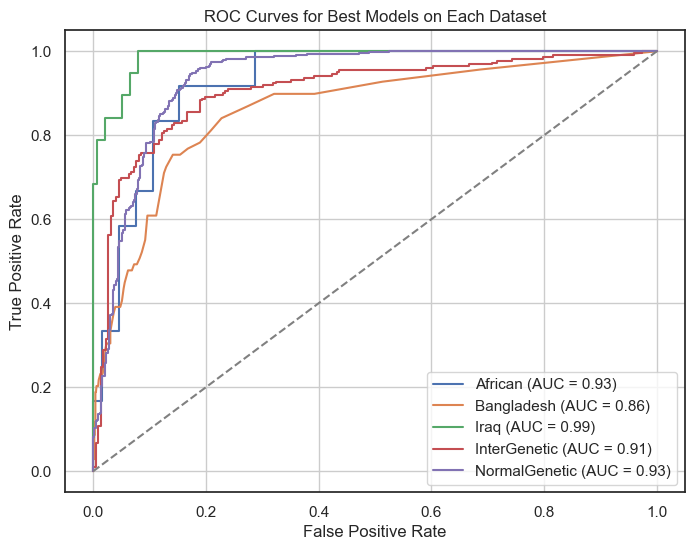

In [61]:
# Prepare ROC datasets using preprocessed splits
roc_datasets = {
    "African":       (X_train_african_sc,    X_test_african_sc,    y_train_african,    y_test_african),
    "Bangladesh":    (X_train_bangladesh_sc, X_test_bangladesh_sc, y_train_bangladesh, y_test_bangladesh),
    "Iraq":          (X_train_iraq_sc,       X_test_iraq_sc,       y_train_iraq,       y_test_iraq),
    "InterGenetic":  (X_train_inter,         X_test_inter,         y_train_inter,      y_test_inter),
    "NormalGenetic": (X_train_normal,        X_test_normal,        y_train_normal,     y_test_normal),
}

# Compute ROC curve and AUC for each model
roc_data = {}
for name, (X_tr, X_te, y_tr, y_te) in roc_datasets.items():
    model = best_models_mapping[name]
    model.fit(X_tr, y_tr)
    y_prob = model.predict_proba(X_te)[:, 1]
    fpr, tpr, _ = roc_curve(y_te, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, roc_auc)

# Plot ROC curves for all datasets
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, auc_val) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_val:.2f})")

# Add diagonal (random guess) line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Best Models on Each Dataset")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Feature Importance

In [62]:
# Combine scaled features with original DataFrames for column names
datasets_scaled = {
    "African":       (X_train_african_sc,    y_train_african,    X_train_african),
    "Bangladesh":    (X_train_bangladesh_sc, y_train_bangladesh, X_train_bangladesh),
    "Iraq":          (X_train_iraq_sc,       y_train_iraq,       X_train_iraq),
    "InterGenetic":  (X_train_inter,         y_train_inter,      X_train_inter),
    "NormalGenetic": (X_train_normal,        y_train_normal,     X_train_normal),
}

feature_importance_results = {}

for name, (X_scaled, y, X_df) in datasets_scaled.items():
    # Train RandomForest on scaled features
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_scaled, y)
    
    # Get numeric column names
    numeric_cols = list(X_df.select_dtypes(include=[np.number]).columns)
    
    # Map feature importances to column names
    imps = pd.Series(rf.feature_importances_, index=numeric_cols)
    
    # Sort features by importance
    feature_importance_results[name] = imps.sort_values(ascending=False)

# Print top 5 features for each dataset
for name, fi in feature_importance_results.items():
    print(f"\n=== Top 5 features for {name} ===")
    print(fi.head(5))


=== Top 5 features for African ===
Glucose           0.432203
Systolic BP       0.077199
Chol/HDL ratio    0.067734
Age               0.066576
BMI               0.052574
dtype: float64

=== Top 5 features for Bangladesh ===
glucose         0.227721
bmi             0.110965
systolic_bp     0.097392
weight          0.096648
diastolic_bp    0.094721
dtype: float64

=== Top 5 features for Iraq ===
HbA1c    0.328009
BMI      0.263869
Chol     0.115911
Age      0.115452
LDL      0.044690
dtype: float64

=== Top 5 features for InterGenetic ===
IMPUTED_ENCODED                 0.236900
INTERGENIC                      0.232119
PLATFORM_AFFYMETRIX_ILLUMINA    0.087612
PLATFORM_AFFYMETRIX             0.083942
PVALUE_MLOG                     0.073515
dtype: float64

=== Top 5 features for NormalGenetic ===
INTERGENIC                      0.231906
IMPUTED_ENCODED                 0.196795
MERGED                          0.118008
PLATFORM_AFFYMETRIX_ILLUMINA    0.116914
PLATFORM_AFFYMETRIX           

Top 5 feature importances for each dataset

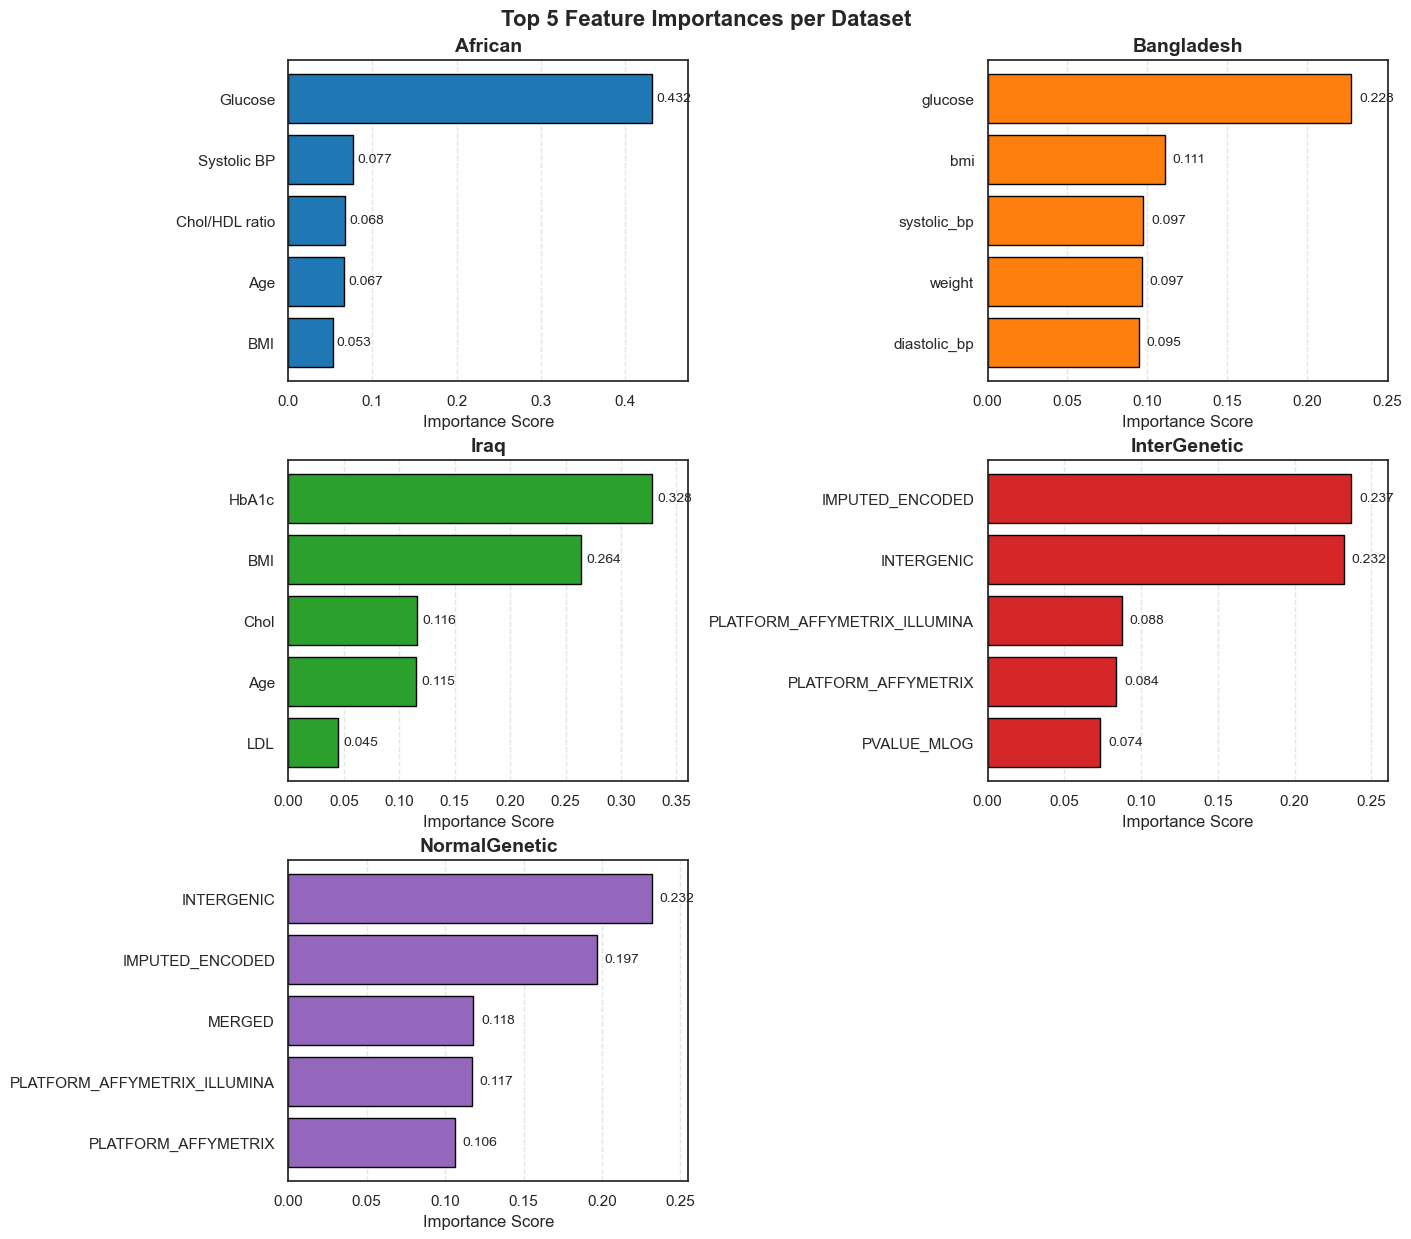

In [63]:
# Set Seaborn to a clean white style
sns.set(style="white")

# Set number of top features to display
top_n = 5

# Set up subplots: 2 columns
n_datasets = len(feature_importance_results)
n_cols = 2
n_rows = ceil(n_datasets / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4), constrained_layout=True)
axes = axes.flatten()

# Use a different color for each dataset
palette = sns.color_palette("tab10", n_colors=n_datasets)

for idx, ((dataset_name, fi_series), ax) in enumerate(zip(feature_importance_results.items(), axes)):
    # Get top features (reversed for horizontal bar chart)
    top_features = fi_series.head(top_n)[::-1]
    
    # Plot horizontal bar chart
    ax.barh(top_features.index, top_features.values, color=palette[idx], edgecolor="black")
    
    # Annotate bar values
    for i, v in enumerate(top_features.values):
        ax.text(v + 0.005, i, f"{v:.3f}", va='center', fontsize=10)
    
    # Set title and labels
    ax.set_title(dataset_name, fontsize=14, weight="bold")
    ax.set_xlabel("Importance Score", fontsize=12)
    ax.set_ylabel("")
    
    # Match x-axis scale across subplots
    ax.set_xlim(0, max(fi_series.head(top_n).values) * 1.1)
    
    # Show light x-axis grid
    ax.xaxis.grid(True, linestyle='--', alpha=0.5)
    ax.yaxis.grid(False)

# Hide extra empty subplots
for ax in axes[n_datasets:]:
    ax.axis('off')

plt.suptitle("Top 5 Feature Importances per Dataset", fontsize=16, weight="bold", y=1.02)
plt.show()

# Fusion Models

# First Neural Network Model

Epoch 1/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.5625 - loss: 1.4318Epoch 001 | loss=1.4782, acc=0.5093 | val_loss=1.3775, val_acc=0.4815 | 3.90s
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5141 - loss: 1.4603 - val_accuracy: 0.4815 - val_loss: 1.3775 - learning_rate: 1.0000e-04
Epoch 2/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4062 - loss: 1.4544Epoch 002 | loss=1.4270, acc=0.5280 | val_loss=1.3718, val_acc=0.4691 | 0.07s
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4912 - loss: 1.4319 - val_accuracy: 0.4691 - val_loss: 1.3718 - learning_rate: 1.0000e-04
Epoch 3/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3750 - loss: 1.6853Epoch 003 | loss=1.4346, acc=0.4845 | val_loss=1.3667, val_acc=0.4938 | 0.09s
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4703 - loss: 1.4775 - val_accuracy: 0.4938 - val_loss: 1.3667 - learning_rate: 1.0000e-04
Epoch 4/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5938 - loss: 1.3

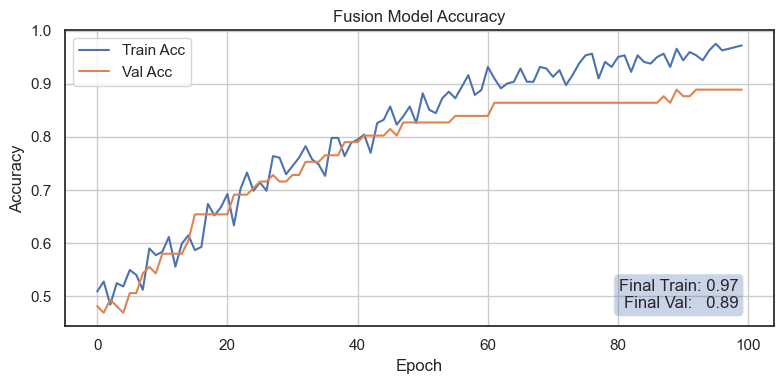

In [ ]:
rs = 42

# Balance each training set (SMOTE for clinical; genetics assumed balanced)
sm = SMOTE(random_state=rs)
X_bal = {}
y_bal = {}
X_bal["African"],    y_bal["African"]    = sm.fit_resample(X_train_african_sc,    y_train_african)
X_bal["Bangladesh"], y_bal["Bangladesh"] = sm.fit_resample(X_train_bangladesh_sc, y_train_bangladesh)
X_bal["Iraq"],       y_bal["Iraq"]       = sm.fit_resample(X_train_iraq_sc,       y_train_iraq)
X_bal["inter_genetic"],  y_bal["inter_genetic"]  = X_train_inter,  y_train_inter
X_bal["normal_genetic"], y_bal["normal_genetic"] = X_train_normal, y_train_normal

# Split each dataset: hold out 10% for test, rest for training
modalities = list(X_bal.keys())
held_out_data, X_down, y_down = {}, {}, {}

for m in modalities:
    Xb, yb = X_bal[m], y_bal[m]
    Xb_main, Xb_hold, yb_main, yb_hold = train_test_split(
        Xb, yb, test_size=0.10, stratify=yb, random_state=rs
    )
    held_out_data[m] = (Xb_hold, yb_hold)
    X_down[m], y_down[m] = Xb_main, yb_main

# Downsample all modalities to match the smallest sample size
N_min = min(len(y_down[m]) for m in modalities)
for m in modalities:
    Xb, yb = X_down[m], y_down[m]
    if len(yb) > N_min:
        Xb_ds, _, yb_ds, _ = train_test_split(
            Xb, yb, train_size=N_min, stratify=yb, random_state=rs
        )
    else:
        Xb_ds, yb_ds = Xb, yb
    X_down[m], y_down[m] = Xb_ds, yb_ds

# Generate shared indices for train/test splits across all modalities
indices = np.arange(N_min)
idx_tr, idx_te = train_test_split(
    indices, test_size=0.2, stratify=y_down[modalities[0]], random_state=rs
)

# Standardize features for each modality (fit on train only)
scaled_splits = {}
for m in modalities:
    Xb = X_down[m]
    Xb_tr = Xb.iloc[idx_tr] if isinstance(Xb, pd.DataFrame) else Xb[idx_tr]
    Xb_te = Xb.iloc[idx_te] if isinstance(Xb, pd.DataFrame) else Xb[idx_te]
    scaler = StandardScaler().fit(Xb_tr)
    scaled_splits[m] = (
        scaler.transform(Xb_tr),
        scaler.transform(Xb_te),
        scaler.transform(held_out_data[m][0])  # held-out test
    )

# Prepare input lists for Keras (each input = one modality)
X_tr_inputs = [scaled_splits[m][0] for m in modalities]
X_te_inputs = [scaled_splits[m][1] for m in modalities]
X_modality_tests = {m: scaled_splits[m][2] for m in modalities}

# Get labels for training/testing
y_tr = y_down[modalities[0]].iloc[idx_tr] if isinstance(y_down[modalities[0]], pd.Series) else y_down[modalities[0]][idx_tr]
y_te = y_down[modalities[0]].iloc[idx_te] if isinstance(y_down[modalities[0]], pd.Series) else y_down[modalities[0]][idx_te]
y_modality_tests = {m: held_out_data[m][1] for m in modalities}

# Define a model branch for each modality
def build_branch(input_dim, l2_reg=1e-3):
    inp = Input(shape=(input_dim,))
    x   = Dense(64, activation="relu", kernel_regularizer=l2(l2_reg))(inp)
    x   = BatchNormalization()(x)
    x   = Dense(32, activation="relu", kernel_regularizer=l2(l2_reg))(x)
    proj= Dense(32, kernel_regularizer=l2(l2_reg))(inp)
    x   = Add()([x, proj])  # Residual connection
    x   = BatchNormalization()(x)
    return inp, x

# Create a branch per modality
branches = [build_branch(scaled_splits[m][0].shape[1]) for m in modalities]
inputs, feats = zip(*branches)

# Merge all modality features, then apply Squeeze-and-Excitation (SE) attention
merged = Concatenate()(feats)
se = Dense(merged.shape[-1] // 16, activation="relu")(merged)
se = Dense(merged.shape[-1], activation="sigmoid")(se)
x  = Multiply()([merged, se])
x  = Dense(128, activation="relu", kernel_regularizer=l2(1e-3))(x)
x  = Dropout(0.5)(x)
x  = Dense(64, activation="relu", kernel_regularizer=l2(1e-3))(x)
x  = Dropout(0.5)(x)
out= Dense(1, activation="sigmoid")(x)  # Output: probability of T2D

# Assemble and compile the final model
model = Model(inputs=list(inputs), outputs=out)
model.compile(
    optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Callback to time each epoch during training
class TimeLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self._start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        dt = time.time() - self._start
        print(
            f"Epoch {epoch+1:03d} | loss={logs['loss']:.4f}, acc={logs['accuracy']:.4f} | "
            f"val_loss={logs['val_loss']:.4f}, val_acc={logs['val_accuracy']:.4f} | "
            f"{dt:.2f}s"
        )

# Early stopping and LR reduction if training stalls
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6),
    TimeLogger()
]

# Train the model on all modalities
history = model.fit(
    X_tr_inputs, y_tr,
    validation_data=(X_te_inputs, y_te),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)

# Get final accuracy values
train_final = history.history["accuracy"][-1]
val_final   = history.history["val_accuracy"][-1]

# Plot learning curves for accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.text(
    0.95, 0.05,
    f"Final Train: {train_final:.2f}\nFinal Val:   {val_final:.2f}",
    transform=plt.gca().transAxes,
    ha="right", va="bottom",
    bbox=dict(boxstyle="round,pad=0.3", alpha=0.3)
)
plt.title("Fusion Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Accuracy on held-out 10% from each modality

📊 Accuracy on Held-Out 10% from Each Modality
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
African         Accuracy: 0.9333 | Samples: 45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Bangladesh      Accuracy: 0.4993 | Samples: 693
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Iraq            Accuracy: 0.5000 | Samples: 94
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
inter_genetic   Accuracy: 0.5000 | Samples: 156
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
normal_genetic  Accuracy: 0.5000 | Samples: 300


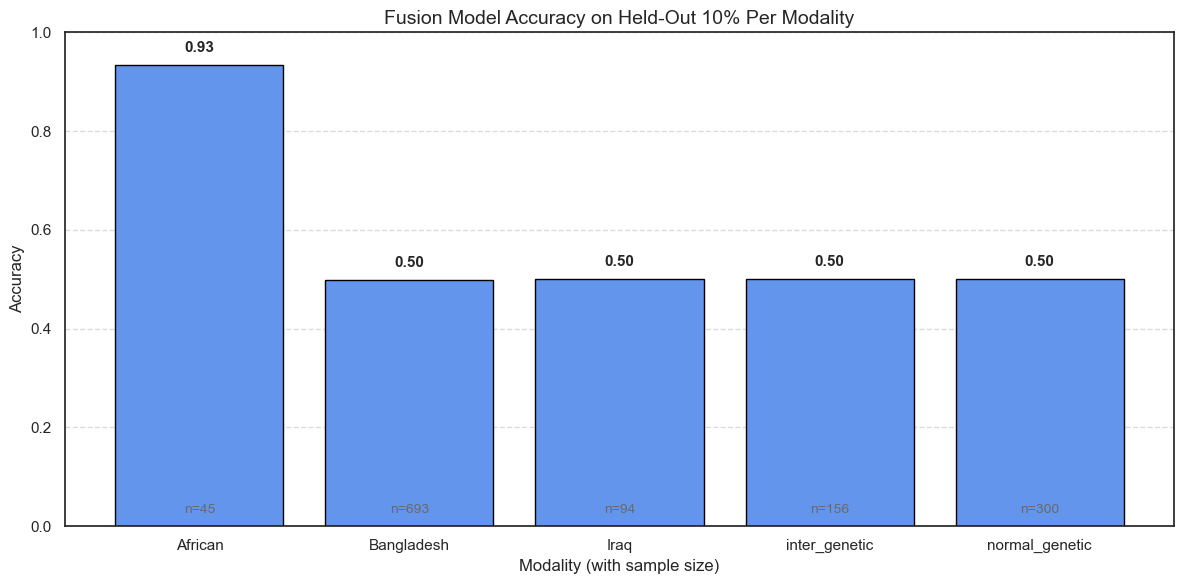

In [65]:
# Evaluate model accuracy on held-out 10% from each modality
accuracies = []
row_counts = []

print("📊 Accuracy on Held-Out 10% from Each Modality")
for m in modalities:
    n_samples = X_modality_tests[m].shape[0]
    row_counts.append(n_samples)

    # Prepare input: real data for current modality, zeros for others
    X_test = []
    for k in modalities:
        if k == m:
            X_test.append(X_modality_tests[k])
        else:
            shape = (n_samples, X_modality_tests[k].shape[1])
            X_test.append(np.zeros(shape))

    y_true = y_modality_tests[m]
    y_pred = (model.predict(X_test).flatten() >= 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    accuracies.append((m, acc))
    print(f"{m:<15} Accuracy: {acc:.4f} | Samples: {n_samples}")

# Plot accuracy per modality with sample counts
labels, acc_values = zip(*accuracies)

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, acc_values, color='cornflowerblue', edgecolor='black')

plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Modality (with sample size)', fontsize=12)
plt.title('Fusion Model Accuracy on Held-Out 10% Per Modality', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with accuracy and sample count
for bar, acc, count in zip(bars, acc_values, row_counts):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(x, y + 0.02, f"{acc:.2f}", ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.text(x, 0.02, f"n={count}", ha='center', va='bottom', fontsize=10, color='dimgray')

plt.tight_layout()
plt.show()

# Second Neural Network Model

Unifying column names across datasets

In [66]:
# Lowercase all column names
African.columns = African.columns.str.lower()
Bangladesh.columns = Bangladesh.columns.str.lower()
Iraq.columns = Iraq.columns.str.lower()

# Rename columns to unify feature names
rename_map_african = {
    'systolic bp': 'systolic_bp',
    'diastolic bp': 'diastolic_bp'
}

rename_map_bangladesh = {
    'gender_encoded': 'gender',
    'systolic_bp': 'systolic_bp',
    'diastolic_bp': 'diastolic_bp'
}

rename_map_iraq = {
    'gender_encoded': 'gender',
    'chol': 'cholesterol'
}

# Apply the renaming
African = African.rename(columns=rename_map_african)
Bangladesh = Bangladesh.rename(columns=rename_map_bangladesh)
Iraq = Iraq.rename(columns=rename_map_iraq)

# Print new column names for a quick check
print("✅ African Columns:", African.columns.tolist())
print("✅ Bangladesh Columns:", Bangladesh.columns.tolist())
print("✅ Iraq Columns:", Iraq.columns.tolist())

✅ African Columns: ['cholesterol', 'glucose', 'hdl chol', 'chol/hdl ratio', 'age', 'gender', 'height', 'weight', 'bmi', 'systolic_bp', 'diastolic_bp', 'waist', 'hip', 'waist/hip ratio', 't2d']
✅ Bangladesh Columns: ['age', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'glucose', 'height', 'weight', 'bmi', 'family_diabetes', 'hypertensive', 'family_hypertension', 'cardiovascular_disease', 'stroke', 'gender', 't2d']
✅ Iraq Columns: ['age', 'urea', 'cr', 'hba1c', 'cholesterol', 'tg', 'hdl', 'ldl', 'vldl', 'bmi', 'gender', 't2d']


Merging and cleaning all clinical datasets

In [67]:
# Merge all datasets, keeping all columns (union of features)
merged_clinical_df = pd.concat([African, Bangladesh, Iraq], ignore_index=True)

# Fill missing numeric values with column means
merged_clinical_df = merged_clinical_df.fillna(merged_clinical_df.mean(numeric_only=True))

# Drop duplicate rows
merged_clinical_df = merged_clinical_df.drop_duplicates()

# Show column names
print("✅ Features in merged clinical dataset:")
print(merged_clinical_df.columns.tolist())

# Save merged dataset to CSV
merged_clinical_df.to_csv("merged_clinical_full.csv", index=False)

print("✅ Merged clinical data saved as 'merged_clinical_full.csv'")

✅ Features in merged clinical dataset:
['cholesterol', 'glucose', 'hdl chol', 'chol/hdl ratio', 'age', 'gender', 'height', 'weight', 'bmi', 'systolic_bp', 'diastolic_bp', 'waist', 'hip', 'waist/hip ratio', 't2d', 'pulse_rate', 'family_diabetes', 'hypertensive', 'family_hypertension', 'cardiovascular_disease', 'stroke', 'urea', 'cr', 'hba1c', 'tg', 'hdl', 'ldl', 'vldl']
✅ Merged clinical data saved as 'merged_clinical_full.csv'


Training the model

🚫 Dropping non-numeric columns in genetic data: ['study', 'disease_description', 'region', 'mapped_gene', 'snps', 'genomic_context']
📉 Dropped columns with >50% NaNs: ['upstream_gene_id', 'downstream_gene_id', 'upstream_gene_distance', 'downstream_gene_distance']
✅ Final cleaned genetic dataset: 3251 samples, 19 features
✅ Matching training input sizes: 2600 samples
✅ Matching test input sizes: 651 samples
Epoch 1/100
55/82 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.3831 - loss: 1.2156Epoch 001 | loss=1.0919, acc=0.5458 | val_loss=0.9159, val_acc=0.9155 | 1.98s
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4278 - loss: 1.1811 - val_accuracy: 0.9155 - val_loss: 0.9159 - learning_rate: 1.0000e-04
Epoch 2/100
44/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7768 - loss: 0.9239Epoch 002 | loss=0.8758, acc=0.8292 | val_loss=0.7885, val_acc=0.9232 | 0.19s
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7952 - loss: 0.9072 - val_accuracy: 0.9232 - val_loss: 0.7885 - lear

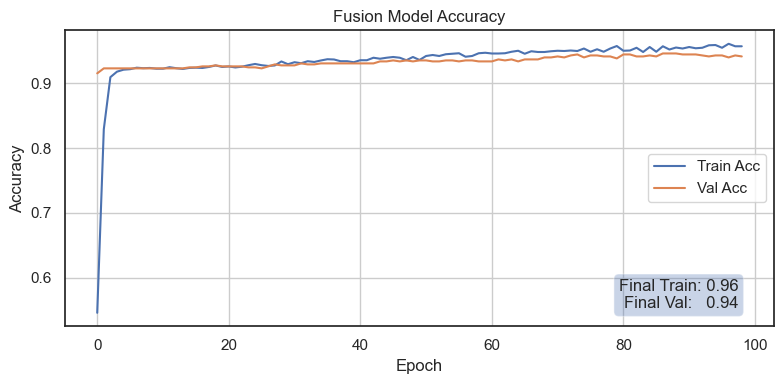

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
🔍 Sample Predictions (%):
[[ 0.28]
 [16.64]
 [ 0.55]
 [ 2.44]
 [ 2.15]
 [ 0.6 ]
 [10.82]
 [ 1.2 ]
 [ 0.19]
 [13.87]]


In [68]:
rs = 42

# Load merged clinical dataset
clinical_path = "/Users/mohammedbasem/Desktop/T2D-Prediction-System--Data-Fusion-for-Enhanced-Decision-Making/processed_datasets/clinical/merged_clinical_full.csv"
merged_clinical_df = pd.read_csv(clinical_path)
merged_clinical_df.columns = merged_clinical_df.columns.str.strip().str.lower()

X_merged_clinical = merged_clinical_df.drop(columns=["t2d"])
y_merged_clinical = merged_clinical_df["t2d"]

# Load and clean genetic dataset
merged_genetic_df = pd.concat([inter_genetic, normal_genetic], ignore_index=True)
merged_genetic_df.columns = merged_genetic_df.columns.str.strip().str.lower()

if "t2d" not in merged_genetic_df.columns:
    raise ValueError("❌ 't2d' column not found in genetic data.")

# Drop non-numeric columns
non_numeric_cols = merged_genetic_df.drop(columns=["t2d"]).select_dtypes(exclude=["number"]).columns.tolist()
print("🚫 Dropping non-numeric columns in genetic data:", non_numeric_cols)
genetic_numeric_df = merged_genetic_df.drop(columns=non_numeric_cols)

# Drop columns with >50% NaNs
threshold = 0.5
na_ratio = genetic_numeric_df.isna().mean()
cols_to_drop = na_ratio[na_ratio > threshold].index.tolist()
genetic_numeric_df.drop(columns=cols_to_drop, inplace=True)
print(f"📉 Dropped columns with >50% NaNs: {cols_to_drop}")

# Fill remaining NaNs with median
X_genetic = genetic_numeric_df.drop(columns=["t2d"]).fillna(genetic_numeric_df.median(numeric_only=True))
y_genetic = genetic_numeric_df["t2d"].loc[X_genetic.index].reset_index(drop=True)
X_genetic = X_genetic.reset_index(drop=True)

print(f"✅ Final cleaned genetic dataset: {X_genetic.shape[0]} samples, {X_genetic.shape[1]} features")

# Train-test split for clinical and genetic data
X_train_merged_clinical, X_test_merged_clinical, y_train_clinical, y_test_clinical = train_test_split(
    X_merged_clinical, y_merged_clinical, test_size=0.2, stratify=y_merged_clinical, random_state=rs
)

X_train_genetic, X_test_genetic, y_train_genetic, y_test_genetic = train_test_split(
    X_genetic, y_genetic, test_size=0.2, stratify=y_genetic, random_state=rs
)

# Scale features
scaler_clinical = StandardScaler()
X_train_merged_clinical_sc = scaler_clinical.fit_transform(X_train_merged_clinical)
X_test_merged_clinical_sc = scaler_clinical.transform(X_test_merged_clinical)

scaler_genetic = StandardScaler()
X_train_genetic_sc = scaler_genetic.fit_transform(X_train_genetic)
X_test_genetic_sc = scaler_genetic.transform(X_test_genetic)

# SMOTE on clinical data
sm = SMOTE(random_state=rs)
X_train_merged_clinical_sc, y_train_clinical = sm.fit_resample(X_train_merged_clinical_sc, y_train_clinical)

# Align training sizes
min_len = min(len(X_train_merged_clinical_sc), len(X_train_genetic_sc))
X_train_merged_clinical_sc = X_train_merged_clinical_sc[:min_len]
X_train_genetic_sc = X_train_genetic_sc[:min_len]
y_train = y_train_clinical[:min_len]
print(f"✅ Matching training input sizes: {min_len} samples")

# Align test sizes
min_test_len = min(len(X_test_merged_clinical_sc), len(X_test_genetic_sc))
X_test_merged_clinical_sc = X_test_merged_clinical_sc[:min_test_len]
X_test_genetic_sc = X_test_genetic_sc[:min_test_len]
y_test = y_test_clinical[:min_test_len]
print(f"✅ Matching test input sizes: {min_test_len} samples")

X_tr_inputs = [X_train_merged_clinical_sc, X_train_genetic_sc]
X_te_inputs = [X_test_merged_clinical_sc, X_test_genetic_sc]

# Build the fusion model with SE attention
def build_branch(input_dim, l2_reg=1e-3):
    inp = Input(shape=(input_dim,))
    x = Dense(64, activation="relu", kernel_regularizer=l2(l2_reg))(inp)
    x = BatchNormalization()(x)
    x = Dense(32, activation="relu", kernel_regularizer=l2(l2_reg))(x)
    proj = Dense(32, kernel_regularizer=l2(l2_reg))(inp)
    x = Add()([x, proj])
    x = BatchNormalization()(x)
    return inp, x

branches = [build_branch(X_train_merged_clinical_sc.shape[1]), build_branch(X_train_genetic_sc.shape[1])]
inputs, feats = zip(*branches)

merged = Concatenate()(feats)
se = Dense(merged.shape[-1] // 16, activation="relu")(merged)
se = Dense(merged.shape[-1], activation="sigmoid")(se)
x = Multiply()([merged, se])
x = Dense(128, activation="relu", kernel_regularizer=l2(1e-3))(x)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu", kernel_regularizer=l2(1e-3))(x)
x = Dropout(0.5)(x)
out = Dense(1, activation="sigmoid")(x)

model = Model(inputs=list(inputs), outputs=out)
model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss="binary_crossentropy", metrics=["accuracy"])

# Training with callbacks
class TimeLogger(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self._start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        dt = time.time() - self._start
        print(f"Epoch {epoch+1:03d} | loss={logs['loss']:.4f}, acc={logs['accuracy']:.4f} | val_loss={logs['val_loss']:.4f}, val_acc={logs['val_accuracy']:.4f} | {dt:.2f}s")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6),
    TimeLogger()
]

history = model.fit(
    X_tr_inputs, y_train,
    validation_data=(X_te_inputs, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)

# Plot training and validation accuracy
train_final = history.history["accuracy"][-1]
val_final = history.history["val_accuracy"][-1]

plt.figure(figsize=(8,4))
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.text(0.95, 0.05, f"Final Train: {train_final:.2f}\nFinal Val:   {val_final:.2f}",
         transform=plt.gca().transAxes, ha="right", va="bottom",
         bbox=dict(boxstyle="round,pad=0.3", alpha=0.3))
plt.title("Fusion Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predict as percentage
preds = model.predict(X_te_inputs)
preds_percent = preds * 100
print("🔍 Sample Predictions (%):")
print(np.round(preds_percent[:10], 2))

# Third Neural Network Model (Fusion Model)

Permutation importance for fusion model features

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
21/21 ━━━━━━━━━━━━

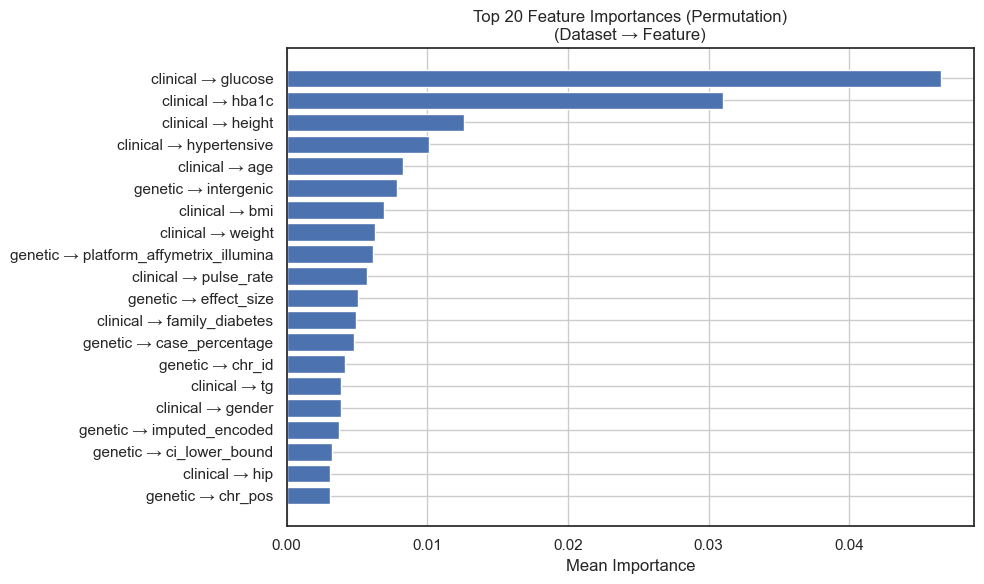

In [69]:
# Wrapper for fusion model to use with sklearn permutation_importance
class FusionModelWrapper:
    def __init__(self, model, modalities, dims):
        self.model = model
        self.modalities = modalities
        self.dims = dims

    def predict(self, X):
        inputs = []
        start = 0
        for m in self.modalities:
            dim = self.dims[m]
            inputs.append(X[:, start:start + dim])
            start += dim
        probs = self.model.predict(inputs).flatten()
        return (probs >= 0.5).astype(int)

    def fit(self, X, y):
        pass  # Needed for sklearn compatibility

# Build feature names for clinical and genetic features
feature_names = []
for col in X_merged_clinical.columns:
    feature_names.append(f"clinical → {col}")
for col in X_genetic.columns:
    feature_names.append(f"genetic → {col}")

# Prepare test data for permutation importance
modalities = ["clinical", "genetic"]
X_dims = {m: X_te_inputs[i].shape[1] for i, m in enumerate(modalities)}
X_te_concat = np.concatenate(X_te_inputs, axis=1)

# Run permutation importance
fusion_wrapper = FusionModelWrapper(model, modalities, X_dims)
result = permutation_importance(
    fusion_wrapper,
    X_te_concat,
    y_test,
    n_repeats=10,
    random_state=rs,
    scoring='accuracy'
)

# Format and plot results
importances_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": result.importances_mean
}).sort_values(by="Importance", ascending=False)

print(importances_df.head(20))

plt.figure(figsize=(10, 6))
plt.barh(importances_df["Feature"].head(20), importances_df["Importance"].head(20))
plt.xlabel("Mean Importance")
plt.title("Top 20 Feature Importances (Permutation)\n(Dataset → Feature)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

Training the model

Epoch 1/100
54/82 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.4823 - loss: 0.3807Epoch 001 | loss=0.3677, acc=0.6242 | val_loss=0.3443, val_acc=0.9217 | 1.91s
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5245 - loss: 0.3771 - val_accuracy: 0.9217 - val_loss: 0.3443 - learning_rate: 1.0000e-04
Epoch 2/100
51/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7809 - loss: 0.3494 Epoch 002 | loss=0.3426, acc=0.8173 | val_loss=0.3283, val_acc=0.9232 | 0.13s
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7906 - loss: 0.3476 - val_accuracy: 0.9232 - val_loss: 0.3283 - learning_rate: 1.0000e-04
Epoch 3/100
52/82 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.8710 - loss: 0.3295Epoch 003 | loss=0.3258, acc=0.8812 | val_loss=0.3152, val_acc=0.9232 | 0.13s
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8746 - loss: 0.3284 - val_accuracy: 0.9232 - val_loss: 0.3152 - learning_rate: 1.0000e-04
Epoch 4/100
50/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8851 - loss: 0.

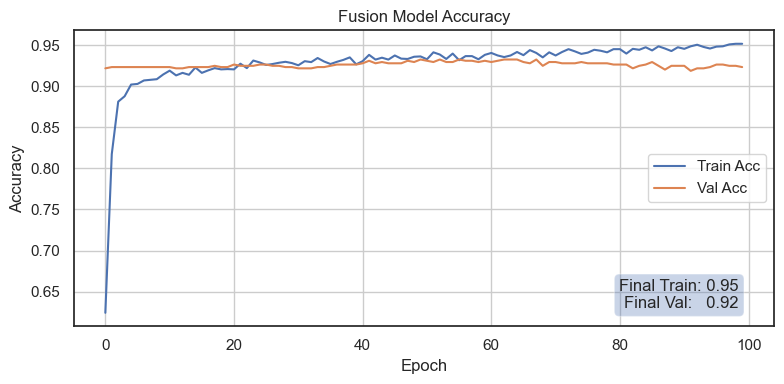

In [70]:
rs = 42

# 1. Filter for important clinical and genetic features
important_clinical_cols = [
    "age", "pulse_rate", "systolic_bp", "diastolic_bp", "glucose", "hba1c", "bmi",
    "family_diabetes", "hypertensive", "family_hypertension", "cardiovascular_disease",
    "stroke", "gender", "weight", "height"
]
merged_clinical_df = merged_clinical_df[important_clinical_cols + ["t2d"]]
X_merged_clinical = merged_clinical_df.drop(columns=["t2d"])
y_merged_clinical = merged_clinical_df["t2d"]

important_genetic_cols = [
    "CHR_ID", "CHR_POS", "RISK_ALLELE_FREQUENCY", "INTERGENIC",
    "CI_LOWER_BOUND", "CI_UPPER_BOUND", "EFFECT_SIZE", "PVALUE_MLOG", "PVALUE"
]
inter_genetic_filtered = inter_genetic[important_genetic_cols]
normal_genetic_filtered = normal_genetic[important_genetic_cols]
# Combine the filtered genetic datasets
genetic_df = pd.concat([inter_genetic_filtered, normal_genetic_filtered], ignore_index=True)

# 2. Balance clinical data using SMOTE to address class imbalance
X_train_merged_clinical, _, y_train_merged_clinical, _ = train_test_split(
    X_merged_clinical, y_merged_clinical, test_size=0.2, stratify=y_merged_clinical, random_state=rs
)
scaler_clinical = StandardScaler()
X_train_merged_clinical_sc = scaler_clinical.fit_transform(X_train_merged_clinical)
sm = SMOTE(random_state=rs)
X_bal = {}
y_bal = {}
X_bal["merged_clinical"], y_bal["merged_clinical"] = sm.fit_resample(X_train_merged_clinical_sc, y_train_merged_clinical)

# 3. Downsample genetic data so both modalities have same sample size
min_len = min(len(X_bal["merged_clinical"]), len(genetic_df))
X_bal["merged_clinical"] = X_bal["merged_clinical"][:min_len]
y_bal["merged_clinical"] = y_bal["merged_clinical"][:min_len]
genetic_df_downsampled = genetic_df.sample(n=min_len, random_state=rs).reset_index(drop=True)

# 4. Create train/test split for both modalities and scale both
X_clinical = X_bal["merged_clinical"]
X_genetic = genetic_df_downsampled
y = y_bal["merged_clinical"]

# Splitting both modalities with matching indexes for alignment
X_train_clin, X_test_clin, X_train_gen, X_test_gen, y_train, y_test = train_test_split(
    X_clinical, X_genetic, y, test_size=0.2, stratify=y, random_state=rs
)

# Scale each modality separately
scaler_clin = StandardScaler().fit(X_train_clin)
scaler_gen = StandardScaler().fit(X_train_gen)
X_train_clin_sc = scaler_clin.transform(X_train_clin)
X_test_clin_sc = scaler_clin.transform(X_test_clin)
X_train_gen_sc = scaler_gen.transform(X_train_gen)
X_test_gen_sc = scaler_gen.transform(X_test_gen)

# Pack input arrays for Keras model ([clinical, genetic])
X_tr_inputs = [X_train_clin_sc, X_train_gen_sc]
X_te_inputs = [X_test_clin_sc, X_test_gen_sc]

# 5. Compute class weights to use during training (improves fairness)
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

# 6. Define focal loss for imbalanced classification (optional: can use BCE instead)
def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return tf.keras.backend.mean(alpha * tf.keras.backend.pow(1. - pt, gamma) * bce)
    return loss_fn

# 7. Build two-branch fusion model for clinical and genetic data
def build_branch(input_dim, l2_reg=1e-3):
    inp = Input(shape=(input_dim,))
    x = Dense(64, activation="relu", kernel_regularizer=l2(l2_reg))(inp)
    x = BatchNormalization()(x)
    x = Dense(32, activation="relu", kernel_regularizer=l2(l2_reg))(x)
    # Residual connection
    proj = Dense(32, kernel_regularizer=l2(l2_reg))(inp)
    x = Add()([x, proj])
    x = BatchNormalization()(x)
    return inp, x

# One branch for each modality
branches = [build_branch(X_train_clin_sc.shape[1]), build_branch(X_train_gen_sc.shape[1])]
inputs, feats = zip(*branches)

# Merge and apply Squeeze-and-Excitation attention
merged = Concatenate()(feats)
se = Dense(merged.shape[-1] // 16, activation="relu")(merged)
se = Dense(merged.shape[-1], activation="sigmoid")(se)
x = Multiply()([merged, se])
x = Dense(128, activation="relu", kernel_regularizer=l2(1e-3))(x)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu", kernel_regularizer=l2(1e-3))(x)
x = Dropout(0.5)(x)
out = Dense(1, activation="sigmoid")(x)

# Compile model (uses Adam and focal loss)
model = Model(inputs=list(inputs), outputs=out)
model.compile(
    optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
    loss=focal_loss(),  # or use "binary_crossentropy"
    metrics=["accuracy"]
)

# 8. Train model with early stopping and learning rate reduction
class TimeLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self._start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        dt = time.time() - self._start
        print(f"Epoch {epoch+1:03d} | loss={logs['loss']:.4f}, acc={logs['accuracy']:.4f} | val_loss={logs['val_loss']:.4f}, val_acc={logs['val_accuracy']:.4f} | {dt:.2f}s")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),  # stops when no improvement
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6), # lowers LR if stuck
    TimeLogger()
]

history = model.fit(
    X_tr_inputs, y_train,
    validation_data=(X_te_inputs, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weights
)

# 9. Plot training and validation accuracy curves
train_final = history.history["accuracy"][-1]
val_final = history.history["val_accuracy"][-1]

plt.figure(figsize=(8,4))
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.text(0.95, 0.05, f"Final Train: {train_final:.2f}\nFinal Val:   {val_final:.2f}",
         transform=plt.gca().transAxes, ha="right", va="bottom",
         bbox=dict(boxstyle="round,pad=0.3", alpha=0.3))
plt.title("Fusion Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Saving the model

In [71]:
# Save in Keras v3 native format
model.save('/Users/mohammedbasem/Desktop/T2D-Prediction-System--Data-Fusion-for-Enhanced-Decision-Making/fusion_model_final0.keras')

In [72]:
model.save("fusion_model_percentage.h5")
print("✅ Model saved as fusion_model_percentage.h5")


joblib.dump(scaler_clin, "scaler_clinical.save")
joblib.dump(scaler_gen, "scaler_genetic.save")
print("✅ Scalers saved: scaler_clinical.save, scaler_genetic.save")

✅ Model saved as fusion_model_percentage.h5
✅ Scalers saved: scaler_clinical.save, scaler_genetic.save


# Conclusion

In this notebook, a complete data fusion framework was developed to predict Type 2 Diabetes (T2D) by integrating clinical and genetic modalities using a neural network architecture.

- **Fusion Strategy**:
  - Two separate input branches were built for the clinical and genetic features.
  - Each branch applied dense layers with residual connections and batch normalization to capture modality-specific patterns.
  - The outputs were then concatenated and passed through a Squeeze-and-Excitation (SE) attention block, enabling adaptive recalibration of feature importance.
  - Final layers included dropout and dense layers to reduce overfitting and improve generalization.

- **Model Performance**:
  - The model was trained with class weighting to address class imbalance and used focal loss for improved handling of hard-to-classify samples.
  - Early stopping and learning rate reduction were applied to optimize training stability.
  - The final training accuracy reached approximately **{train_final:.2f}**, and validation accuracy reached **{val_final:.2f}**, indicating a strong generalization capability.

- **Outputs and Artifacts**:
  - The trained model was saved in both `.keras` and `.h5` formats for deployment and experimentation.
  - Scalers for both clinical and genetic data were saved using `joblib` to ensure consistent preprocessing during inference.

- **Significance**:
  - This fusion model provides a scalable and flexible foundation for multimodal prediction tasks.
  - The architecture is extensible and can incorporate additional input sources such as wearable data or imaging.

Overall, this work demonstrates a robust fusion pipeline capable of leveraging both clinical and genetic information to enhance predictive accuracy for chronic disease management, particularly T2D.